In [10]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
import pandas as pd
# Torch
import torch
import torch.nn as nn
from typing import *

import src.utils as utils
from torch.utils.data import Dataset, DataLoader

In [11]:
# Load all 18 datasets
df_dict: Dict[int, pd.DataFrame]= {}
for subject_code in range(501, 519):
    file_path = f"data/har70plus/{subject_code}.csv" 
    df_dict[subject_code] = pd.read_csv(file_path)

In [12]:
# Examine one csv (subject data)
df = df_dict[501]
df.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,6
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,6
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,6
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,6
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,6


In [13]:
# Check for missing values in all csv files
total_missing = pd.Series(dtype=int)
for df in df_dict.values():
    missing_counts = df.isnull().sum()
    total_missing = total_missing.add(missing_counts, fill_value=0)

total_missing = total_missing.astype(int)
total_missing

back_x       0
back_y       0
back_z       0
label        0
thigh_x      0
thigh_y      0
thigh_z      0
timestamp    0
dtype: int32

In [45]:
label_mapping = {
    1: 0,
    3: 1,
    4: 2,
    5: 3,
    6: 4,
    7: 5,
    8: 6
}


In [46]:
numeric_labels = torch.tensor([1, 3, 6, 7, 4])  # Example labels
text_labels = [label_mapping[label.item()] for label in numeric_labels]
print(text_labels)


[0, 1, 4, 5, 2]


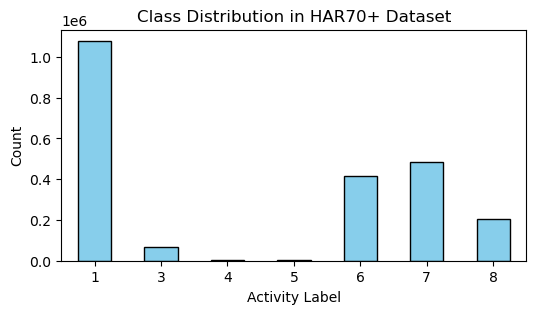

label
1    1079312
3      66058
4       4560
5       4978
6     418055
7     483452
8     203182
dtype: int32

In [14]:
total_counts = pd.Series(dtype=int)
for df in df_dict.values():
    counts = df["label"].value_counts()
    total_counts = total_counts.add(counts, fill_value=0) # `add` automatically aligns indices before summing counts

total_counts = total_counts.astype(int)

plt.figure(figsize=(6, 3))
total_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Activity Label")
plt.ylabel("Count")
plt.title("Class Distribution in HAR70+ Dataset")
plt.xticks(rotation=0)
plt.show()
total_counts


In [49]:
# Convert timestamp to datetime and calculate time differences
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp_diff'] = df['timestamp'].diff().dt.total_seconds()
df['label'] = [label_mapping[label] for label in df['label']]

# Summary statistics of timestamp gaps
print(df['timestamp_diff'].describe())

# Identify breakpoints (where gaps are larger than expected 0.02s)
gap_threshold = 0.05  # Slightly higher than 0.02 to account for minor variations
breakpoints = df[df['timestamp_diff'] > gap_threshold].index

# Print breakpoints
print(f"Identified {len(breakpoints)} breakpoints at indices:", breakpoints.tolist())

count    141713.000000
mean          0.020578
std           0.121197
min           0.019000
25%           0.020000
50%           0.020000
75%           0.020000
max          40.420000
Name: timestamp_diff, dtype: float64
Identified 8 breakpoints at indices: [6353, 22467, 31345, 44355, 54457, 79677, 81581, 137429]


In [50]:
class HARSegmentedDataset(Dataset):
    def __init__(self, df, window_size=100, stride=50, gap_threshold=0.05):
        self.window_size = window_size
        self.stride = stride
        
        # Convert timestamp and calculate time gaps
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['timestamp_diff'] = df['timestamp'].diff().dt.total_seconds()
        
        # Identify breakpoints (indices where gaps exceed threshold)
        breakpoints = df[df['timestamp_diff'] > gap_threshold].index.tolist()
        
        # Split data into continuous segments
        segments = []
        start_idx = 0
        for bp in breakpoints:
            segments.append(df.iloc[start_idx:bp])  # Add previous segment
            start_idx = bp  # Start new segment
        segments.append(df.iloc[start_idx:])  # Add last segment
        
        # Extract valid sequences from each segment
        self.sequences, self.targets = [], []
        sensor_cols = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
        label_col = 'label'

        for segment in segments:
            data = segment[sensor_cols].values
            labels = segment[label_col].values

            # Ensure segment is long enough for at least one full window
            if len(data) < window_size:
                continue  

            for i in range(0, len(data) - window_size + 1, stride):
                self.sequences.append(data[i : i + window_size])
                self.targets.append(labels[i + window_size - 1])  # Many-to-One

        # Convert to tensors
        self.sequences = torch.tensor(self.sequences, dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Example Usage
dataset = HARSegmentedDataset(df, window_size=100, stride=50)
print(f"Total valid sequences: {len(dataset)}")

Total valid sequences: 2822


In [51]:
dataloader = DataLoader(dataset, batch_size = 64, shuffle= True)


In [52]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, \
                 num_layers = 1, dropout = 0.0, num_classes = 7):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, \
                           num_layers = num_layers, 
                           dropout = dropout if num_layers > 1 else 0.0, 
                           batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_seq):
        # For this encoder, we ignore the outputs 
        # We use the final hidden state for the calculation of the logits
        # TODO: some function that will extract actual hidden state, output could only be a function fo hidden state
        outputs, (hn, _) = self.rnn(input_seq)
        logits = self.fc(hn[-1])
        return logits

In [53]:
def train_encoder(model, dataloader, num_epochs, learning_rate):
    model.train()  # Set the model to training mode
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0
        for input_seq, target_seq in dataloader:
            print(target_seq)
            optimizer.zero_grad()
            print(target_seq.shape)
            output_seq = model(input_seq)
            loss = criterion(output_seq, target_seq)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}')

In [54]:
# Hyperparameters
input_size = 6
hidden_size = 30
learning_rate = 0.001
num_epochs = 100
num_layers = 1
dropout_rate = 0.1

encoder = EncoderRNN(input_size, hidden_size, num_layers, dropout_rate)
train_encoder(encoder, dataloader, num_epochs, learning_rate)

tensor([5, 0, 1, 0, 0, 4, 4, 4, 5, 1, 5, 5, 0, 4, 4, 5, 5, 5, 5, 0, 4, 0, 0, 0,
        0, 0, 5, 5, 0, 5, 4, 0, 5, 0, 0, 1, 5, 0, 0, 5, 5, 0, 0, 5, 5, 0, 5, 5,
        5, 0, 4, 0, 5, 0, 5, 0, 5, 5, 4, 5, 5, 0, 5, 5])
torch.Size([64])
tensor([5, 5, 0, 0, 5, 5, 4, 5, 0, 0, 0, 0, 5, 0, 4, 0, 0, 5, 0, 5, 0, 5, 5, 1,
        5, 0, 0, 5, 5, 5, 5, 1, 0, 0, 0, 4, 0, 0, 4, 5, 0, 0, 5, 4, 5, 1, 4, 5,
        0, 4, 5, 0, 1, 0, 0, 0, 0, 4, 5, 0, 0, 5, 0, 0])
torch.Size([64])
tensor([4, 1, 5, 0, 4, 0, 4, 4, 4, 5, 0, 4, 0, 5, 0, 0, 0, 0, 0, 4, 5, 4, 4, 5,
        4, 4, 4, 5, 0, 0, 4, 5, 5, 0, 4, 0, 0, 4, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0,
        5, 0, 0, 0, 0, 4, 0, 4, 0, 5, 0, 5, 1, 5, 0, 0])
torch.Size([64])
tensor([5, 0, 5, 5, 5, 0, 0, 5, 5, 5, 0, 5, 5, 0, 0, 0, 4, 4, 1, 0, 4, 0, 0, 0,
        4, 0, 4, 0, 0, 5, 5, 5, 0, 5, 4, 5, 5, 5, 4, 0, 5, 0, 0, 5, 5, 5, 5, 4,
        0, 5, 4, 4, 0, 0, 4, 0, 0, 5, 5, 0, 5, 0, 5, 0])
torch.Size([64])
tensor([0, 5, 5, 5, 0, 0, 5, 5, 5, 4, 5, 0, 0, 5, 0, 5, 5, 0, 5,

KeyboardInterrupt: 